In [718]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.preprocessing import StandardScaler

### Part 1: Cleveland Heart Attack Dataset

In [719]:
def load_cleveland_data(file_path):
    data = pd.read_csv(file_path)
    data['disease'] = data.num.apply(lambda x: min(x,1))
    
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
    data = data.drop('num', axis=1)
    data = data.dropna()

    X = data.drop('disease', axis=1)
    y = data['disease']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    
    return X_scaled_df.values, y.values, X.columns


In [720]:
class kNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k=3, feature_mask=None):
        self.k = k
        self.feature_mask = feature_mask

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        if self.feature_mask is not None:
            X = X[:, self.feature_mask]
        self.X_ = X
        self.y_ = y
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        if self.feature_mask is not None:
            X = X[:, self.feature_mask]
        return np.array([self._predict(x) for x in X])

    def _predict(self, x):
        distances = [np.sqrt(np.sum((x - x_train) ** 2)) for x_train in self.X_]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_[i] for i in k_indices]
        return np.argmax(np.bincount(k_nearest_labels))

In [721]:
def cross_validate(X, y, k, feature_mask, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    f1_scores = []
    precisions = []
    recalls = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = kNN(k=k, feature_mask=feature_mask)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        f1_scores.append(f1_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        
        # print(f"Fold - Precision: {precisions[-1]:.3f}, Recall: {recalls[-1]:.3f}, F1: {f1_scores[-1]:.3f}")
    
    return f1_scores, precisions, recalls

In [722]:
def feature_importance(X, y, feature_names):
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X, y)
    importances = dt.feature_importances_
    feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    return feature_importance

In [723]:
def elbow(X, y, k_range, feature_mask):
    # Apply the feature mask
    X_masked = X[:, feature_mask]

    X_train, X_test, y_train, y_test = train_test_split(X_masked, y, test_size=0.2, random_state=42)

    scores = []
    for k in k_range:
        knn = kNN(k=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        scores.append((precision, recall, f1))

    precisions, recalls, f1_scores = zip(*scores)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, f1_scores)
    plt.xlabel('k')
    plt.ylabel('F1 Score')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [724]:
# Load the data
X, y, feature_names = load_cleveland_data('data/cleveland.csv')

importance_results = feature_importance(X, y, feature_names)
print("Feature Importance:")
print(importance_results)

Feature Importance:
thal        0.279725
cp          0.151193
ca          0.108062
thalach     0.083773
chol        0.079608
oldpeak     0.076073
age         0.072169
trestbps    0.050094
slope       0.031960
sex         0.028341
restecg     0.016259
exang       0.012420
fbs         0.010323
dtype: float64


/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/matt/projects/project4-knn-cs5830/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

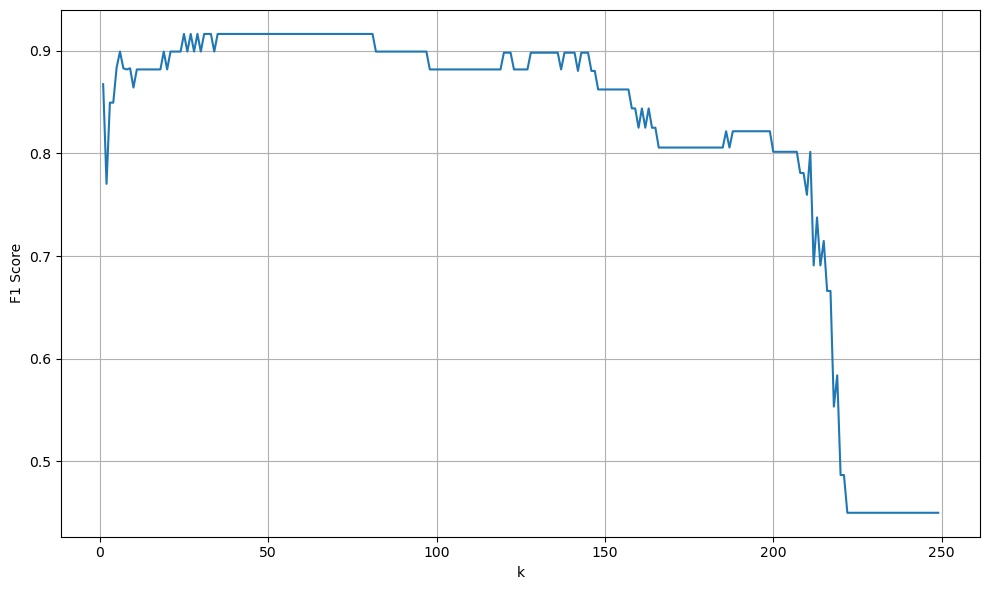

In [725]:
selected_features = ['thal', 'cp', 'ca', 'thalach']

# Create feature mask
feature_mask = np.isin(feature_names, selected_features)

elbow(X, y, range(1, 250), feature_mask)

In [726]:
# Set k based on our elbow plot
k = 150

# Perform cross-validation
f1_scores, precisions, recalls = cross_validate(X, y, k, feature_mask)

# Print results
print(f"Selected features: {selected_features}")
print(f"k value: {k}")
print("\nCross-validation results:")
for i in range(10):
    print(f"Fold {i+1}:")
    print(f"  Precision: {precisions[i]:.3f}")
    print(f"  Recall: {recalls[i]:.3f}")
    print(f"  F1 Score: {f1_scores[i]:.3f}")

print("\nMean scores:")
print(f"Precision: {np.mean(precisions):.3f} (+/- {np.std(precisions):.3f})")
print(f"Recall: {np.mean(recalls):.3f} (+/- {np.std(recalls):.3f})")
print(f"F1 Score: {np.mean(f1_scores):.3f} (+/- {np.std(f1_scores):.3f})")

# Train a model for the test set
final_model = kNN(k=k, feature_mask=feature_mask)
final_model.fit(X, y)

Selected features: ['thal', 'cp', 'ca', 'thalach']
k value: 150

Cross-validation results:
Fold 1:
  Precision: 0.900
  Recall: 0.818
  F1 Score: 0.857
Fold 2:
  Precision: 1.000
  Recall: 0.769
  F1 Score: 0.870
Fold 3:
  Precision: 1.000
  Recall: 0.706
  F1 Score: 0.828
Fold 4:
  Precision: 1.000
  Recall: 0.667
  F1 Score: 0.800
Fold 5:
  Precision: 0.933
  Recall: 0.700
  F1 Score: 0.800
Fold 6:
  Precision: 0.900
  Recall: 0.692
  F1 Score: 0.783
Fold 7:
  Precision: 0.800
  Recall: 0.667
  F1 Score: 0.727
Fold 8:
  Precision: 0.900
  Recall: 0.692
  F1 Score: 0.783
Fold 9:
  Precision: 0.833
  Recall: 0.909
  F1 Score: 0.870
Fold 10:
  Precision: 0.700
  Recall: 0.778
  F1 Score: 0.737

Mean scores:
Precision: 0.897 (+/- 0.092)
Recall: 0.740 (+/- 0.074)
F1 Score: 0.805 (+/- 0.048)


kNN(feature_mask=array([False, False,  True, False, False, False, False,  True, False,
       False, False,  True,  True]),
    k=150)

In [727]:
# Function to predict on challenge dataset
def predict_challenge(challenge_file, model):
    X_challenge, y_challenge, _ = load_data(challenge_file)
    y_pred = model.predict(X_challenge)
    return f1_score(y_challenge, y_pred)

# Predict on the sample test dataset
challenge_f1 = predict_challenge('data/cleveland-test-sample.csv', final_model)
print(f"\nF1 Score on challenge dataset: {challenge_f1:.3f}")


F1 Score on challenge dataset: 0.848


### Part 2: CDC BRFSS 2015 Diabetes Dataset

In [739]:
def load_diabetes_data(file_path):
    data = pd.read_csv(file_path)
    # data['Diabetes_binary'] = data.num.apply(lambda x: min(x,1))
    
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
    # data = data.drop('num', axis=1)
    data = data.dropna()

    X = data.drop('Diabetes_binary', axis=1)
    y = data['Diabetes_binary']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
    
    return X_scaled_df.values, y.values, X.columns

In [740]:
X, y, feature_names= load_diabetes_data('data/diabetes_sample.csv')
importance_results = feature_importance(X, y, feature_names)
print("Feature Importance:")
print(importance_results)

Feature Importance:
BMI                     0.187131
GenHlth                 0.130863
Age                     0.126637
Income                  0.110922
MentHlth                0.078607
Education               0.067365
PhysHlth                0.063850
HighChol                0.049450
DiffWalk                0.036655
PhysActivity            0.022021
HighBP                  0.021847
HeartDiseaseorAttack    0.021308
Sex                     0.016108
Fruits                  0.015553
AnyHealthcare           0.011427
NoDocbcCost             0.010739
Smoker                  0.008224
Veggies                 0.007797
Stroke                  0.007382
HvyAlcoholConsump       0.006111
CholCheck               0.000000
dtype: float64


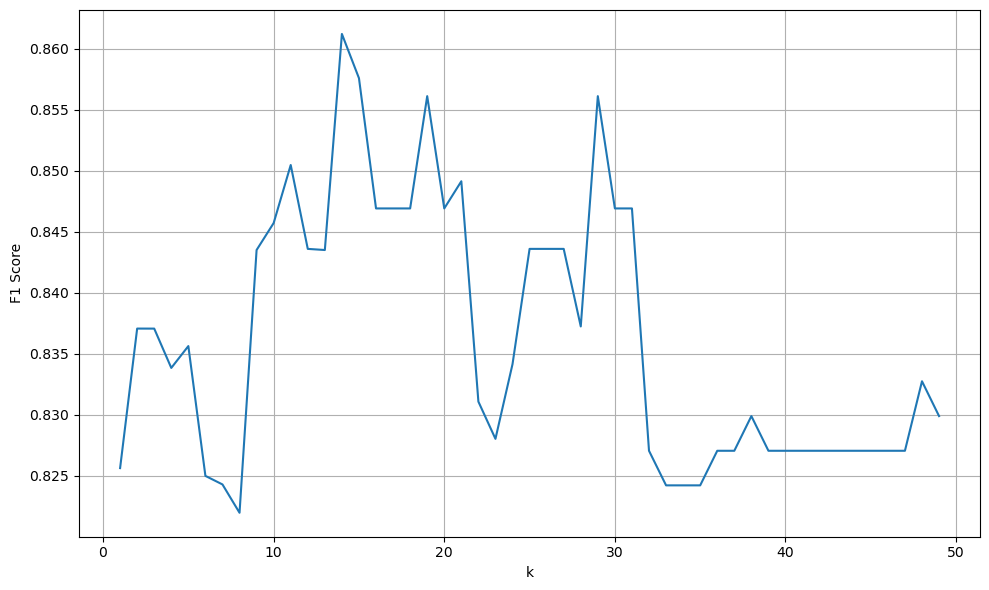

In [750]:
selected_features = ['BMI', 'GenHealth', 'PhysHlth', 'Age', 'HighBP', 'Sex', 'HvyAlcoholConsump', 'HighChol']

# Create feature mask
feature_mask = np.isin(feature_names, selected_features)

elbow(X, y, range(1, 50), feature_mask)

In [755]:
# Set k based on our elbow plot
k = 5

# Perform cross-validation
f1_scores, precisions, recalls = cross_validate(X, y, k, feature_mask)

# Print results
print(f"Selected features: {selected_features}")
print(f"k value: {k}")
print("\nCross-validation results:")
for i in range(10):
    print(f"Fold {i+1}:")
    print(f"  Precision: {precisions[i]:.3f}")
    print(f"  Recall: {recalls[i]:.3f}")
    print(f"  F1 Score: {f1_scores[i]:.3f}")

print("\nMean scores:")
print(f"Precision: {np.mean(precisions):.3f} (+/- {np.std(precisions):.3f})")
print(f"Recall: {np.mean(recalls):.3f} (+/- {np.std(recalls):.3f})")
print(f"F1 Score: {np.mean(f1_scores):.3f} (+/- {np.std(f1_scores):.3f})")

# Train a model for the test set
final_model = kNN(k=k, feature_mask=feature_mask)
final_model.fit(X, y)

Selected features: ['BMI', 'GenHealth', 'PhysHlth', 'Age', 'HighBP', 'Sex', 'HvyAlcoholConsump', 'HighChol']
k value: 5

Cross-validation results:
Fold 1:
  Precision: 0.333
  Recall: 0.111
  F1 Score: 0.167
Fold 2:
  Precision: 0.286
  Recall: 0.133
  F1 Score: 0.182
Fold 3:
  Precision: 0.300
  Recall: 0.167
  F1 Score: 0.214
Fold 4:
  Precision: 0.400
  Recall: 0.111
  F1 Score: 0.174
Fold 5:
  Precision: 0.444
  Recall: 0.400
  F1 Score: 0.421
Fold 6:
  Precision: 0.556
  Recall: 0.500
  F1 Score: 0.526
Fold 7:
  Precision: 0.750
  Recall: 0.176
  F1 Score: 0.286
Fold 8:
  Precision: 0.500
  Recall: 0.167
  F1 Score: 0.250
Fold 9:
  Precision: 0.500
  Recall: 0.222
  F1 Score: 0.308
Fold 10:
  Precision: 0.500
  Recall: 0.333
  F1 Score: 0.400

Mean scores:
Precision: 0.457 (+/- 0.132)
Recall: 0.232 (+/- 0.127)
F1 Score: 0.293 (+/- 0.115)


kNN(feature_mask=array([ True,  True, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False,  True, False,  True,
        True, False, False]),
    k=5)